<a href="https://colab.research.google.com/github/Derun-Chai/Assignment2/blob/https/Assignment_2_part_1(VGG).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Hello everyone! Nowadays I've learnt what is transfer learning and why should we use transfer learning. And in this kernel I am going to apply what I have learnt. Before starting, let's take a look at the content of this kernel

# Notebook Content
1. Importing Necessary Libraries
1. Preparing CIFAR10 Dataset
1. Preparing VGG19 Model
1. Fitting and Evaluating Results
1. Final Test
1. Conclusion

# Importing Necessary Libraries and CIFAR10

In this section I am going to import necessary libraries.

In [7]:
import numpy as np
import cv2
import tensorflow as tf
from keras.applications.vgg19 import VGG19
from keras.layers import Dense, Flatten
from keras.models import Sequential
from keras.utils import to_categorical
from keras.datasets import cifar10

# **GPU Helper Functions**

To use a GPU, if one is available, we define a couple of helper functions (get_default_device & to_device) and a helper class DeviceDataLoader to move our model & data to the GPU as required

In [8]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("No GPU found, model will train on CPU.")

# Preparing CIFAR10 Dataset

In this section I am going to load CIFAR10 dataset. But before, I want to explain what is CIFAR10

*The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class.*

*From Wikipedia*

In [6]:
# Load CIFAR10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


* As we can see our images are 32x32x3, they are too small for using them in VGG19. Therefore, we need to expand them.

In [9]:
# Resize images
def resize_img(img):
    numberOfImage = img.shape[0]
    new_array = np.zeros((numberOfImage, 48, 48, 3))
    for i in range(numberOfImage):
        new_array[i] = cv2.resize(img[i, :, :, :], (48, 48))
    return new_array


* Now, let's use this function in order to expand our images to 48x48

In [10]:
x_train = resize_img(x_train)
x_test = resize_img(x_test)


* Our images are ready, but I can't say the same for labels. Let's prepare our labels.

In [11]:
# one hot encoding
y_train = to_categorical(y_train,num_classes=10)
y_test = to_categorical(y_test,num_classes=10)

# Display shapes
print("Shape of x_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of x_train: (50000, 48, 48, 3)
Shape of y_train: (50000, 10)
Shape of x_test: (10000, 48, 48, 3)
Shape of y_test: (10000, 10)


# Preparing VGG19 Model

Our dataset is ready, now we need a model. In this section I am going to prepare pre trained VGG19 model.

In [12]:
# Include top = add fully connected layers to layer.
# Weights = use pretrained weights (trained in imagenet)
vgg = VGG19(include_top=False,weights="imagenet",input_shape=(48,48,3))

vgg.summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                              

* VGG19 looks good, but it needs fully connected layers 😜
* Now I am going to create a blank model, then I will add all the layers of VGG19 to that model and add fully connnected layers.


In [13]:
model = Sequential()

# Adding layers to the blank model
for layer in vgg.layers:
    model.add(layer)
    layer.trainable = False

# Adding fully connected layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation="softmax"))

# Checking model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 12, 12, 256)       2

* Everything is ready, yayy.
* Let's train our model and test it.

# Fitting and Evaluating Model
In this section I am going to fit the model. It will be easyyy.

In [14]:
# Assuming train_loader_on_device and val_loader_on_device have been created as in previous discussions


# Compile the model
model.compile(optimizer='Adam', loss="categorical_crossentropy", metrics=["accuracy"])
# Splitting dataset into training and validation. Assuming 15% validation.
validation_split = 0.15
split_at = int(x_train.shape[0] * (1 - validation_split))
x_val = x_train[split_at:]
y_val = y_train[split_at:]
x_train = x_train[:split_at]
y_train = y_train[:split_at]
# Train the model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=400)



Epoch 1/20
107/107 [==============================] - 28s 154ms/step - loss: 4.6158 - accuracy: 0.4084 - val_loss: 2.2322 - val_accuracy: 0.4693
Epoch 2/20
107/107 [==============================] - 13s 119ms/step - loss: 1.7777 - accuracy: 0.4972 - val_loss: 1.6088 - val_accuracy: 0.5143
Epoch 3/20
107/107 [==============================] - 13s 121ms/step - loss: 1.3768 - accuracy: 0.5557 - val_loss: 1.4454 - val_accuracy: 0.5520
Epoch 4/20
107/107 [==============================] - 13s 123ms/step - loss: 1.1986 - accuracy: 0.6006 - val_loss: 1.3783 - val_accuracy: 0.5663
Epoch 5/20
107/107 [==============================] - 13s 126ms/step - loss: 1.0904 - accuracy: 0.6295 - val_loss: 1.3340 - val_accuracy: 0.5815
Epoch 6/20
107/107 [==============================] - 14s 127ms/step - loss: 1.0082 - accuracy: 0.6570 - val_loss: 1.3061 - val_accuracy: 0.5879
Epoch 7/20
107/107 [==============================] - 14s 129ms/step - loss: 0.9469 - accuracy: 0.6759 - val_loss: 1.2917 - val_ac

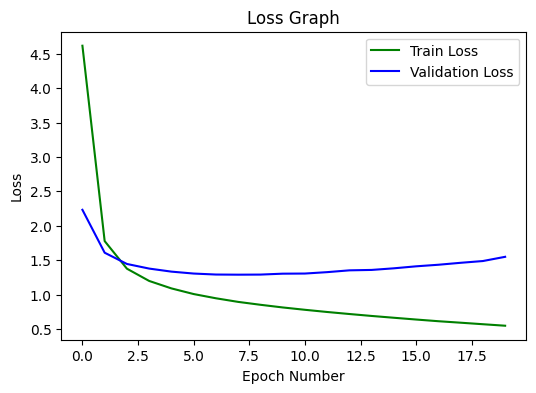

In [16]:
import matplotlib.pyplot as plt
plt.subplots(figsize=(6,4))
plt.plot(history.epoch,history.history["loss"],color="green",label="Train Loss")
plt.plot(history.epoch,history.history["val_loss"],color="blue",label="Validation Loss")
plt.xlabel("Epoch Number")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Graph")
plt.show()

* What a graph!

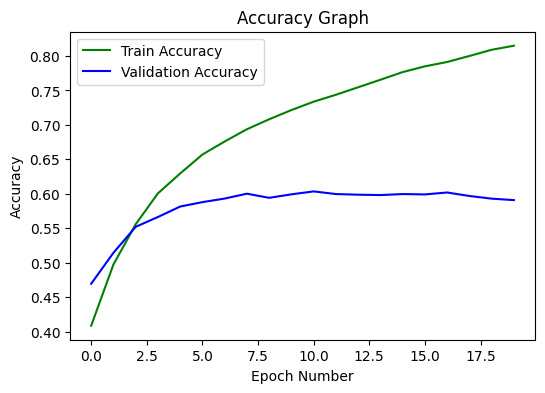

In [18]:
plt.subplots(figsize=(6,4))
plt.plot(history.epoch,history.history["accuracy"],color="green",label="Train Accuracy")
plt.plot(history.epoch,history.history["val_accuracy"],color="blue",label="Validation Accuracy")
plt.xlabel("Epoch Number")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Graph")
plt.show()

# Final Test
In this section I am going to test the model using our test set.

In [19]:
model.evaluate(x_test,y_test)

313/313 [==============================] - 5s 16ms/step - loss: 1.5659 - accuracy: 0.5890


[1.5659457445144653, 0.5889999866485596]

313/313 [==============================] - 4s 14ms/step


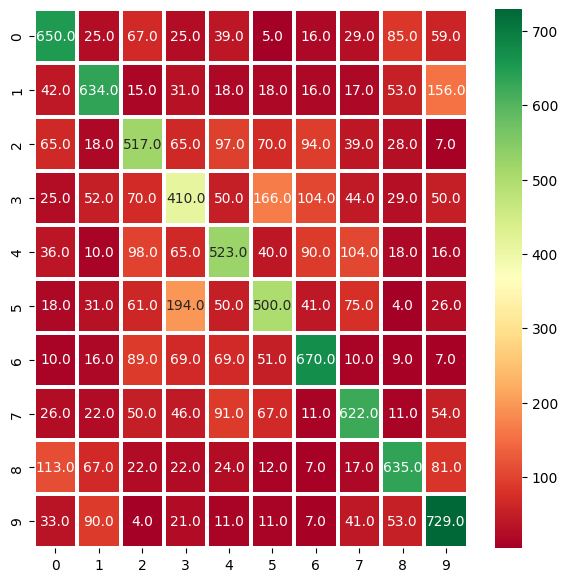

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_probabilities = model.predict(x_test)
y_pred = np.argmax(y_probabilities, axis=1)

conf_matrix = confusion_matrix(y_pred=y_pred,y_true=[np.where(r==1)[0][0] for r in y_test])

plt.subplots(figsize=(7,7))
sns.heatmap(conf_matrix,annot=True,linewidths=1.5,fmt=".1f",cmap="RdYlGn")
plt.show()